<h1><center> REINFORCEMENT LEARNING FOR STOCK TRADING </center></h1>
<h2><center> DUEL Q-LEARNING MODELS </center></h2>

## 1. SOURCES




### A CURATED LIST OF ML FOR FINANCE APPLICATIONS

https://github.com/firmai/financial-machine-learning

### APPLICATIONS FROM THE COLLABORATIVE PLATFORM BY GOOGLE

https://colab.research.google.com/drive/1FzLCI0AO3c7A4bp9Fi01UwXeoc7BN8sW

### SEQUENCE FOR LEARNING TO BUILD A REINFORCEMENT LEARNING MODEL WITH TENSORFLOW

https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0


### REINFORCEMENT LEARNING

https://frnsys.com/ai_notes/artificial_intelligence/reinforcement_learning.html


## 2. CREATING THE DATA FILE

In [10]:
## Further  recommendation, test multiple frameworks, see what works better on average. 
## Open source RL: https://docs.google.com/spreadsheets/d/1EeFPd-XIQ3mq_9snTlAZSsFY7Hbnmd7P5bbT8LPuMn0/edit#gid=0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [11]:

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
df_full = pdr.get_data_yahoo("JPM", start="2000-01-01").reset_index()
df_full.to_csv('JPM.csv',index=False)
df_full.head()


,Date,High,Low,Open,Close,Volume,Adj Close
0,2000-01-03,50.250000,48.083332,49.833332,48.583332,12019200.0,26.681709
1,2000-01-04,47.458332,46.125000,47.083332,47.250000,11723400.0,26.170267
2,2000-01-05,48.375000,46.000000,46.833332,46.958332,8714500.0,26.008717
3,2000-01-06,48.625000,46.500000,46.750000,47.625000,8369200.0,26.377962
4,2000-01-07,49.000000,47.333332,48.416668,48.500000,6571900.0,26.862602


In [12]:
df_full = pd.read_csv('JPM.csv')

## 3. DUEL Q-LEARNING AGENT

This section is based on **Yoon, C (2019), `Dueling Deep Q Networks`** at  https://towardsdatascience.com/dueling-deep-q-networks-81ffab672751

### 3.1. DIFFERENCE BETWEEN Q AND V

https://medium.com/@zsalloum/q-vs-v-in-reinforcement-learning-the-easy-way-9350e1523031

Think of it as the commander assessing the outcome (value V) of each situation (state s) . The situation outcome would be like the advantage he has over the enemy forces. Consequently he will be asking himself about the best action to take in order to have the best outcome.
Intuitively, the best policy is to have the maximum outcome in each situation.
So we define the optimal value function V*(s) as the maximum values that can be obtained after checking all policies to V(s) for all states.


Think of it as the commander assessing the outcome (value V) of each situation (state s) . The situation outcome would be like the advantage he has over the enemy forces. Consequently he will be asking himself about the best action to take in order to have the best outcome.
Intuitively, the best policy is to have the maximum outcome in each situation.
So we define the optimal value function V*(s) as the maximum values that can be obtained after checking all policies to V(s) for all states.


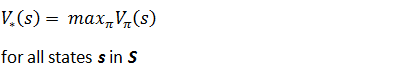

In other words, the commander is presented with different strategies by his lieutenants and he chooses the one that will maximize the outcome on each state.

However the best situation is the result of actions, so at each state the commander will have to check the contribution of each action to the optimal policy (or strategy):

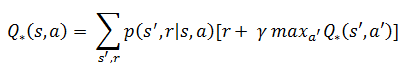

In the battle scenario, Q*(s, a) gives the effectiveness of each action (rope, ladder, siege tower) while at the attack state, knowing that at the next state (next stage of the battle), the commander’s best action is to use large number of troops to fight inside the fortress.

Q*(s, a) tells that once at state s, take some action a to leave s and arrive to state s’, collect the rewards and then continue to take the best action a’ that will result in the best value of Q*(s’, a’).
In the battle scenario, Q*(s, a) gives the effectiveness of each action (rope, ladder, siege tower) while at the attack state, knowing that at the next state (next stage of the battle), the commander’s best action is to use large number of troops to fight inside the fortress.

Given the effectiveness of action a at state s returned by Q*(s, a), telling the best value of the state is simply getting the maximum value of all available actions at that state:


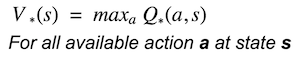

In summary, V*(s) gives the best value of each state s when applying an optimal policy. On the other hand Q*(a , s) gives the effectiveness of action a at state s while applying the optimal policy on all other states.
It follows that V*(s) = max( Q*(a , s) ) for all a available at s.


### 3.2. DUEL Q-LEARNING MODELS

(Wang et al.) presents the novel dueling architecture which explicitly separates the representation of state values and state-dependent action advantages via two separate streams.

The key motivation behind this architecture is that for some games, it is unnecessary to know the value of each action at every timestep. The authors give an example of the Atari game Enduro, where it is not necessary to know which action to take until collision is imminent.

By explicitly separating two estimators, the dueling architecture can learn which states are (or are not) valuable, without having to learn the effect of each action for each state. Like the Enduro example, this architecture becomes especially more relevant in tasks where actions might not always affect the environment in meaningful ways.


### ARCHITECTURE

Like the standard DQN architecture, we have convolutional layers to process game-play frames. From there, we split the network into two separate streams, one for estimating the state-value and the other for estimating state-dependent action advantages. After the two streams, the last module of the network combines the state-value and advantage outputs.

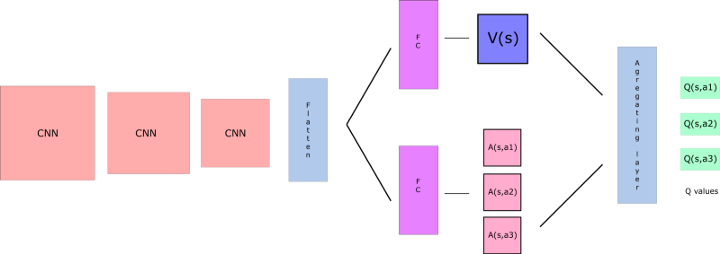

It seems intuitive to just sum the two values, as immediately obvious from the definition of the advantage value:

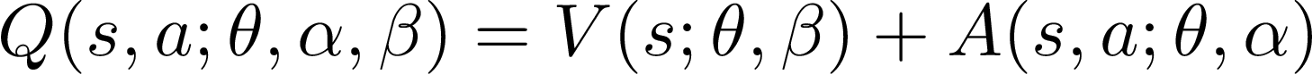

In [13]:
## Duel Q-learning agent

from collections import deque
import random
from tensorflow.python.framework import ops
ops.reset_default_graph()

df= df_full.copy()
name = 'Duel Q-learning agent'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 512, activation = tf.nn.relu)
        tensor_action, tensor_validation = tf.split(feed,2,1)
        feed_action = tf.layers.dense(tensor_action, self.action_size)
        feed_validation = tf.layers.dense(tensor_validation, 1)
        self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)



Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
epoch: 10, total rewards: 98.886271.3, cost: 0.082641, total money: 10098.886271
epoch: 20, total rewards: 86.082119.3, cost: 0.061751, total money: 10086.082119
epoch: 30, total rewards: 45.147160.3, cost: 0.049219, total money: 10045.147160
epoch: 40, total rewards: 48.387976.3, cost: 0.041254, total money: 10048.387976
epoch: 50, total rewards: 29.418377.3, cost: 0.035711, total money: 10029.418377
epoch: 60, total rewards: 51.418379.3, cost: 0.031870, total money: 10051.418379
epoch: 70, total rewards: 31.290869.3, cost: 0.028930, total money: 10031.290869
epoch: 80, total rewards: 4.000044.3, cost: 0.024269, total money: 10004.000044
epoch: 90, total rewards: 13.014172.3, cost: 0.024904, total money: 10013.014172
epoch: 100, total rewards: 24.411674.3, cost: 0.023504, total money: 10024.411674
day 4: buy 1 unit at price 48.500000, total balance 9951.500

day 533: buy 1 unit at price 29.410000, total balance 9951.751661
day 535, sell 1 unit at price 28.190001, investment -4.148247 %, total balance 9979.941662,
day 540: buy 1 unit at price 29.660000, total balance 9950.281662
day 541: buy 1 unit at price 32.500000, total balance 9917.781662
day 542, sell 1 unit at price 32.509998, investment 9.608896 %, total balance 9950.291660,
day 543, sell 1 unit at price 34.049999, investment 4.769228 %, total balance 9984.341660,
day 554: buy 1 unit at price 34.790001, total balance 9949.551659
day 556, sell 1 unit at price 34.950001, investment 0.459902 %, total balance 9984.501659,
day 557: buy 1 unit at price 35.150002, total balance 9949.351658
day 559, sell 1 unit at price 35.650002, investment 1.422475 %, total balance 9985.001659,
day 566: buy 1 unit at price 35.189999, total balance 9949.811661
day 567, sell 1 unit at price 35.040001, investment -0.426251 %, total balance 9984.851662,
day 569: buy 1 unit at price 34.279999, total balance 99

day 1102: buy 1 unit at price 36.080002, total balance 9945.701662
day 1103, sell 1 unit at price 36.840000, investment 2.106425 %, total balance 9982.541662,
day 1109: buy 1 unit at price 36.959999, total balance 9945.581663
day 1110: buy 1 unit at price 37.279999, total balance 9908.301664
day 1111, sell 1 unit at price 38.139999, investment 3.192642 %, total balance 9946.441664,
day 1112, sell 1 unit at price 38.060001, investment 2.092282 %, total balance 9984.501665,
day 1131: buy 1 unit at price 36.860001, total balance 9947.641665
day 1132: buy 1 unit at price 36.750000, total balance 9910.891665
day 1135, sell 1 unit at price 37.139999, investment 0.759628 %, total balance 9948.031664,
day 1136, sell 1 unit at price 36.450001, investment -0.816324 %, total balance 9984.481665,
day 1138: buy 1 unit at price 35.869999, total balance 9948.611666
day 1142, sell 1 unit at price 36.779999, investment 2.536939 %, total balance 9985.391665,
day 1154: buy 1 unit at price 36.070000, tota

day 1698, sell 1 unit at price 47.490002, investment -0.544499 %, total balance 9988.741674,
day 1701: buy 1 unit at price 47.110001, total balance 9941.631674
day 1703, sell 1 unit at price 47.639999, investment 1.125024 %, total balance 9989.271673,
day 1710: buy 1 unit at price 47.119999, total balance 9942.151674
day 1711: buy 1 unit at price 47.389999, total balance 9894.761675
day 1712, sell 1 unit at price 47.139999, investment 0.042446 %, total balance 9941.901674,
day 1713, sell 1 unit at price 47.270000, investment -0.253216 %, total balance 9989.171675,
day 1718: buy 1 unit at price 46.930000, total balance 9942.241674
day 1720, sell 1 unit at price 46.889999, investment -0.085235 %, total balance 9989.131674,
day 1727: buy 1 unit at price 47.750000, total balance 9941.381674
day 1728, sell 1 unit at price 47.450001, investment -0.628271 %, total balance 9988.831675,
day 1733: buy 1 unit at price 47.590000, total balance 9941.241674
day 1734: buy 1 unit at price 47.270000, t

day 2292: buy 1 unit at price 24.690001, total balance 9968.411676
day 2293, sell 1 unit at price 21.650000, investment -17.334864 %, total balance 9990.061676,
day 2295, sell 1 unit at price 20.600000, investment -16.565411 %, total balance 10010.661676,
day 2303: buy 1 unit at price 21.010000, total balance 9989.651676
day 2305, sell 1 unit at price 16.600000, investment -20.990004 %, total balance 10006.251677,
day 2308: buy 1 unit at price 19.500000, total balance 9986.751677
day 2310, sell 1 unit at price 23.200001, investment 18.974363 %, total balance 10009.951677,
day 2314: buy 1 unit at price 27.110001, total balance 9982.841677
day 2315, sell 1 unit at price 24.950001, investment -7.967539 %, total balance 10007.791677,
day 2323: buy 1 unit at price 26.580000, total balance 9981.211678
day 2325, sell 1 unit at price 28.160000, investment 5.944319 %, total balance 10009.371677,
day 2337: buy 1 unit at price 32.529999, total balance 9976.841679
day 2340, sell 1 unit at price 33

day 2813, sell 1 unit at price 45.529999, investment -2.212205 %, total balance 10020.311695,
day 2818: buy 1 unit at price 44.560001, total balance 9975.751694
day 2819, sell 1 unit at price 45.740002, investment 2.648116 %, total balance 10021.491695,
day 2831: buy 1 unit at price 46.580002, total balance 9974.911694
day 2832: buy 1 unit at price 47.639999, total balance 9927.271694
day 2834, sell 1 unit at price 46.840000, investment 0.558176 %, total balance 9974.111694,
day 2835, sell 1 unit at price 46.860001, investment -1.637277 %, total balance 10020.971695,
day 2839: buy 1 unit at price 44.889999, total balance 9976.081696
day 2841: buy 1 unit at price 44.650002, total balance 9931.431694
day 2842, sell 1 unit at price 44.560001, investment -0.735126 %, total balance 9975.991695,
day 2844, sell 1 unit at price 44.610001, investment -0.089588 %, total balance 10020.601696,
day 2847: buy 1 unit at price 45.849998, total balance 9974.751698
day 2850, sell 1 unit at price 45.9199

day 3375: buy 1 unit at price 53.029999, total balance 9953.711687
day 3378, sell 1 unit at price 54.360001, investment 2.508018 %, total balance 10008.071688,
day 3389: buy 1 unit at price 52.080002, total balance 9955.991686
day 3391: buy 1 unit at price 53.150002, total balance 9902.841684
day 3392, sell 1 unit at price 52.790001, investment 1.363285 %, total balance 9955.631685,
day 3394, sell 1 unit at price 52.799999, investment -0.658518 %, total balance 10008.431684,
day 3397: buy 1 unit at price 54.700001, total balance 9953.731684
day 3398, sell 1 unit at price 54.889999, investment 0.347347 %, total balance 10008.621683,
day 3420: buy 1 unit at price 54.830002, total balance 9953.791681
day 3421: buy 1 unit at price 54.520000, total balance 9899.271681
day 3423: buy 1 unit at price 54.290001, total balance 9844.981680
day 3424, sell 1 unit at price 54.150002, investment -1.240197 %, total balance 9899.131681,
day 3425, sell 1 unit at price 53.290001, investment -2.256052 %, 

day 4109: buy 1 unit at price 61.570000, total balance 9886.641684
day 4110, sell 1 unit at price 61.240002, investment -3.997491 %, total balance 9947.881685,
day 4112, sell 1 unit at price 61.209999, investment -0.584701 %, total balance 10009.091684,
day 4115: buy 1 unit at price 61.770000, total balance 9947.321684
day 4119: buy 1 unit at price 64.040001, total balance 9883.281683
day 4121, sell 1 unit at price 63.509998, investment 2.816898 %, total balance 9946.791681,
day 4122, sell 1 unit at price 63.459999, investment -0.905687 %, total balance 10010.251680,
day 4127: buy 1 unit at price 65.269997, total balance 9944.981684
day 4128, sell 1 unit at price 65.690002, investment 0.643490 %, total balance 10010.671686,
day 4133: buy 1 unit at price 65.250000, total balance 9945.421686
day 4134, sell 1 unit at price 64.750000, investment -0.766284 %, total balance 10010.171686,
day 4139: buy 1 unit at price 62.220001, total balance 9947.951685
day 4140: buy 1 unit at price 62.27999

day 4718: buy 1 unit at price 115.040001, total balance 9930.171694
day 4719, sell 1 unit at price 115.269997, investment 0.199927 %, total balance 10045.441690,
day 4722: buy 1 unit at price 114.519997, total balance 9930.921694
day 4723, sell 1 unit at price 111.470001, investment -2.663286 %, total balance 10042.391695,
day 4724: buy 1 unit at price 108.129997, total balance 9934.261698
day 4727, sell 1 unit at price 108.620003, investment 0.453163 %, total balance 10042.881701,
day 4732: buy 1 unit at price 105.250000, total balance 9937.631701
day 4734: buy 1 unit at price 104.860001, total balance 9832.771700
day 4736, sell 1 unit at price 104.849998, investment -0.380049 %, total balance 9937.621698,
day 4737, sell 1 unit at price 106.699997, investment 1.754717 %, total balance 10044.321695,
day 4742: buy 1 unit at price 109.599998, total balance 9934.721697
day 4743, sell 1 unit at price 111.480003, investment 1.715333 %, total balance 10046.201700,
day 4745: buy 1 unit at pri

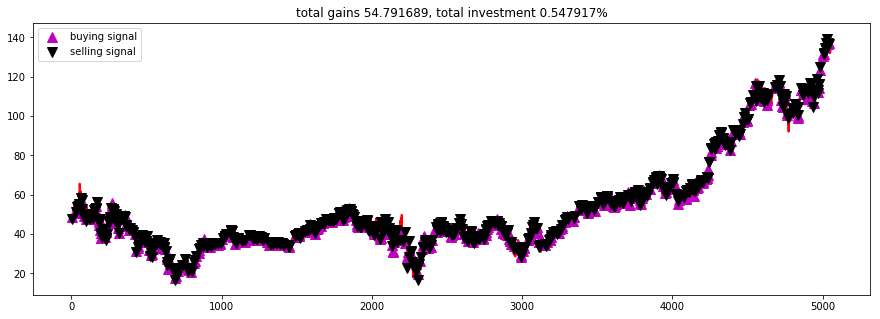

In [15]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
#plt.savefig('output/'+name+'.png')
plt.show()

### 3.10. DOUBLE DUEL Q LEARNING AGENT

In recent years there have been many successes of using deep representations in reinforcement learning. Still, many of these applications use conventional architectures, such as convolutional networks, LSTMs, or auto-encoders. In this paper, we present a new neural network architecture for model-free reinforcement learning. Our dueling network represents two separate estimators: one for the state value function and one for the state-dependent action advantage function. The main benefit of this factoring is to generalize learning across actions without imposing any change to the underlying reinforcement learning algorithm. Our results show that this architecture leads to better policy evaluation in the presence of many similar-valued actions. Moreover, the dueling architecture enables our RL agent to outperform the state-of-the-art on the Atari 2600 domain.

In [34]:
## Double Duel Q-learning agent

from collections import deque
import random

df= df_full.copy()
name = 'Double Duel Q-learning agent'

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        tensor_action, tensor_validation = tf.split(feed,2,1)
        feed_action = tf.layers.dense(tensor_action, output_size)
        feed_validation = tf.layers.dense(tensor_validation, 1)
        self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                state = next_state
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)



D:\Program Files\Anaconda\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 83.590012.3, cost: 0.016299, total money: 9814.330017
epoch: 20, total rewards: -6.219971.3, cost: 0.003634, total money: 9594.150040
epoch: 30, total rewards: 562.899940.3, cost: 0.013938, total money: 8034.789932
epoch: 40, total rewards: 54.620003.3, cost: 0.003916, total money: 9785.360008
epoch: 50, total rewards: -9.049988.3, cost: 0.005215, total money: 9990.950012
epoch: 60, total rewards: 14.299942.3, cost: 0.008442, total money: 9475.739960
epoch: 70, total rewards: 39.789978.3, cost: 0.002630, total money: 10039.789978
epoch: 80, total rewards: 39.820015.3, cost: 0.000927, total money: 9766.940025
epoch: 90, total rewards: 65.730064.3, cost: 0.007150, total money: 9928.140068
epoch: 100, total rewards: 56.439995.3, cost: 0.002518, total money: 10056.439995
day 1: buy 1 unit at price 108.059998, total balance 9891.940002
day 2, sell 1 unit at price 109.040001, investment 0.906907 %, total balance 10000.980003,
day 9: buy 1 unit at price 112.269997, t

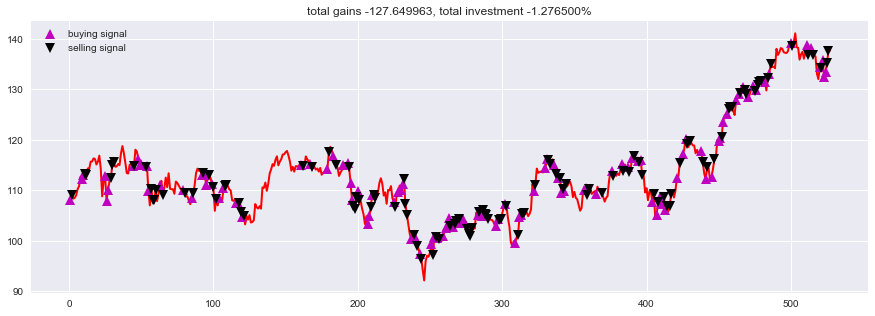

In [35]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
#plt.savefig('output/'+name+'.png')
plt.show()

### 3.11 DOUBLE DUEL RECURRENT Q LEARNING AGENT

In [39]:
## Double Duel Recurrent Q-learning agent

from collections import deque
import random

df= df_full.copy()
name = 'Double Duel Recurrent Q-learning agent'

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate, name):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, None, input_size))
            self.Y = tf.placeholder(tf.float32, (None, output_size))
            cell = tf.nn.rnn_cell.LSTMCell(layer_size, state_is_tuple = False)
            self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * layer_size))
            self.rnn,self.last_state = tf.nn.dynamic_rnn(inputs=self.X,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
            tensor_action, tensor_validation = tf.split(self.rnn[:,-1],2,1)
            feed_action = tf.layers.dense(tensor_action, output_size)
            feed_validation = tf.layers.dense(tensor_validation, 1)
            self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
            self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
            self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE,
                           'real_model')
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE,
                                   'negative_model')
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self, from_name, to_name):
        from_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_name)
        to_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_name)
        for i in range(len(from_w)):
            assign_op = to_w[i].assign(from_w[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, dead, rnn_state):
        self.MEMORIES.append((state, action, reward, new_state, dead, rnn_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        init_values = np.array([a[-1] for a in replay])
        Q = self.sess.run(self.model.logits, feed_dict={self.model.X:states, 
                                                   self.model.hidden_layer:init_values})
        Q_new = self.sess.run(self.model.logits, feed_dict={self.model.X:new_states, 
                                                       self.model.hidden_layer:init_values})
        Q_new_negative = self.sess.run(self.model_negative.logits, 
                                  feed_dict={self.model_negative.X:new_states, 
                                             self.model_negative.hidden_layer:init_values})
        replay_size = len(replay)
        X = np.empty((replay_size, 4, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        INIT_VAL = np.empty((replay_size, 2 * self.LAYER_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, dead_r, rnn_memory = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not dead_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
            INIT_VAL[i] = rnn_memory
        return X, Y, INIT_VAL
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        init_value = np.zeros((1, 2 * self.LAYER_SIZE))
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(self.trend) - 1, self.skip):
            action, last_state = self.sess.run([self.model.logits,self.model.last_state],
                                                feed_dict={self.model.X:[self.INITIAL_FEATURES],
                                                            self.model.hidden_layer:init_value})
            action, init_value = np.argmax(action[0]), last_state
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign('real_model', 'negative_model')
                
                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:
                    action, last_state = self.sess.run([self.model.logits,
                                                  self.model.last_state],
                                                  feed_dict={self.model.X:[self.INITIAL_FEATURES],
                                                             self.model.hidden_layer:init_value})
                    action, init_value = np.argmax(action[0]), last_state
                    
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
                
                self._memorize(self.INITIAL_FEATURES, action, invest, new_state, 
                               starting_money < initial_money, init_value[0])
                self.INITIAL_FEATURES = new_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y, INIT_VAL = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y,
                                                  self.model.hidden_layer: INIT_VAL})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 20, checkpoint = 10, initial_money = initial_money)

states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)



D:\Program Files\Anaconda\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 377.289970.3, cost: 0.002301, total money: 9017.790001
epoch: 20, total rewards: 432.799965.3, cost: 0.009770, total money: 6269.909981
day 0: buy 1 unit at price 107.949997, total balance 9892.050003
day 1: buy 1 unit at price 108.059998, total balance 9783.990005
day 2, sell 1 unit at price 109.040001, investment 1.009730 %, total balance 9893.030006,
day 3, sell 1 unit at price 108.339996, investment 0.259114 %, total balance 10001.370003,
day 29: buy 1 unit at price 112.430000, total balance 9888.940002
day 30, sell 1 unit at price 115.029999, investment 2.312549 %, total balance 10003.970001,
day 32: buy 1 unit at price 114.680000, total balance 9889.290001
day 33, sell 1 unit at price 114.709999, investment 0.026159 %, total balance 10004.000000,
day 59: buy 1 unit at price 108.000000, total balance 9896.000000
day 60: buy 1 unit at price 109.970001, total balance 9786.029999
day 61, sell 1 unit at price 107.849998, investment -0.138890 %, total balance 

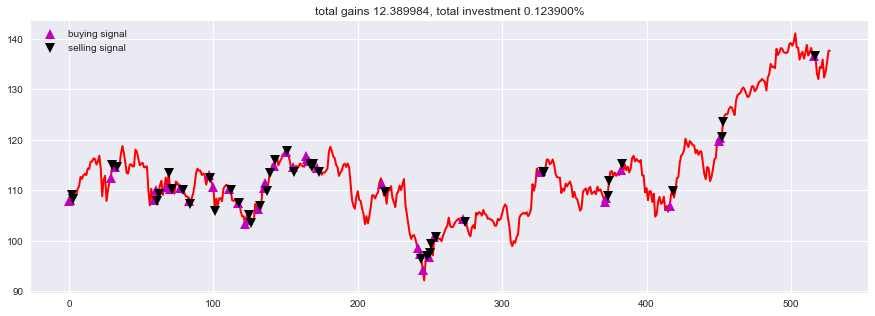

In [40]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
#plt.savefig('output/'+name+'.png')
plt.show()